## Investigate GradCAM explanations for untuned and fmri-tuned AlexNet models

In [1]:
import torch
import torchvision
from torchvision.models import AlexNet_Weights
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt

import os

from PIL import Image

from models import CLR_model
import torchextractor as tx
import joblib
import torch.nn as nn
import torch

from utils import get_dataloaders


In [7]:
project_dir = os.path.join("/Users", "alexm", "fmri_repo")
device = 'cpu'

## Load Untuned Model and Images

In [8]:
# Load untuned model
untuned_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=AlexNet_Weights.IMAGENET1K_V1)
untuned_model.to(device) # Send the model to the chosen device 
untuned_model.eval(); # Set the model to evaluation mode

Using cache found in /Users/alexm/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
# Define image transforms for model input and plotting
alex_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # convert the images to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
                ])
plot_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])

In [17]:
# Load relevant image paths from Caltech256
img_names = ["056_0044.jpg", "056_0094.jpg", "159_0041.jpg", "159_0073.jpg", 
             "159_0141.jpg", "159_0121.jpg", "159_0180.jpg", "121_0001.jpg",
               "121_0041.jpg"]
labels = ["dog", "dog", "people", "people", "people", "people", "people", "kangaroo", "kangaroo"]
img_paths = []
for img_name in img_names:
    img_paths.append(os.path.join(project_dir, "caltech_sample_images", img_name))

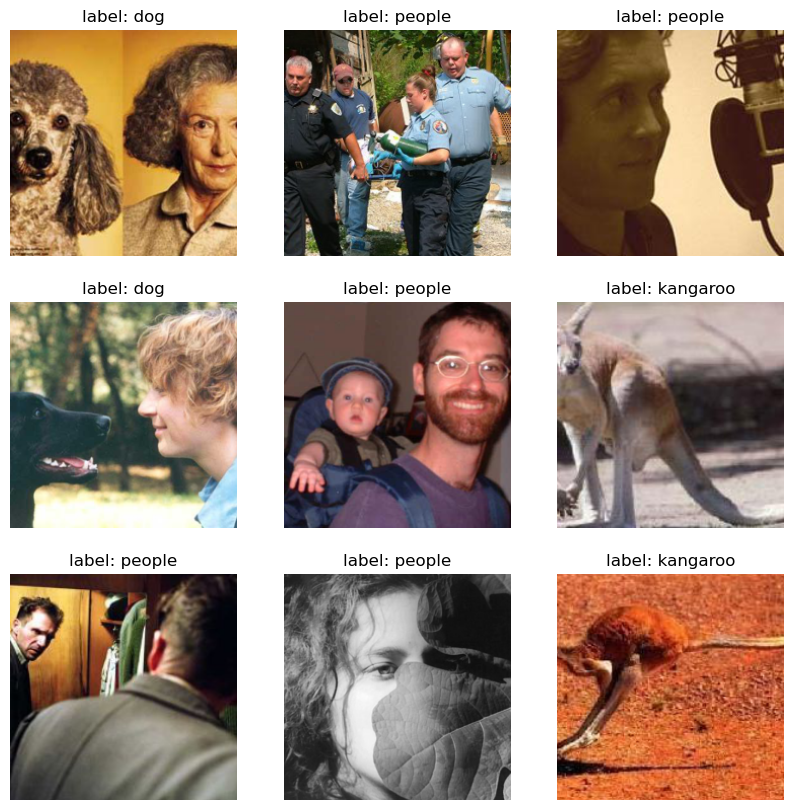

In [18]:
# Display the images in a grid with labels
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
counter = 0
for y_idx in range(3):
    for x_idx in range(3):
        im = Image.open(img_paths[counter]).convert('RGB')
        label_name = labels[counter]
        im = plot_transform(im)
        ax[x_idx, y_idx].imshow(im.permute(1,2,0).numpy())
        ax[x_idx, y_idx].set_title("label: " + label_name)
        ax[x_idx, y_idx].axis('off')
        counter += 1
plt.show()

## Untuned GradCAM

In [19]:
# Load classifier weights+biases for caltech256 
# Note that untuned results are in subj1 left hemisphere for each dataset
untuned_classifier_path = os.path.join(project_dir, "results", "Subj1", "subj1_lh_caltech256_cl_classifier.joblib")

In [20]:
# Create new model class to handle logistic regression classifer head for untuned and tuned models
class gradcam_model(nn.Module):
    def __init__(self, model, num_classes, cl_model=True):
        super(gradcam_model, self).__init__()

        if cl_model:
            self.features = model.alex.features
            self.avgpool = model.alex.avgpool
            self.classifier = nn.Sequential(*list(model.alex.classifier.children())[:-1])
        else:
            self.features = model.features
            self.avgpool = model.avgpool
            self.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
        self.classification_head = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.classification_head(x)
        return x
    
num_classes = 257

Label 55
Predicted Label: tensor(55)
Label 55
Predicted Label: tensor(55)
Label 158
Predicted Label: tensor(158)
Label 158
Predicted Label: tensor(158)
Label 158
Predicted Label: tensor(158)
Label 158
Predicted Label: tensor(158)
Label 158
Predicted Label: tensor(158)
Label 120
Predicted Label: tensor(120)
Label 120
Predicted Label: tensor(120)


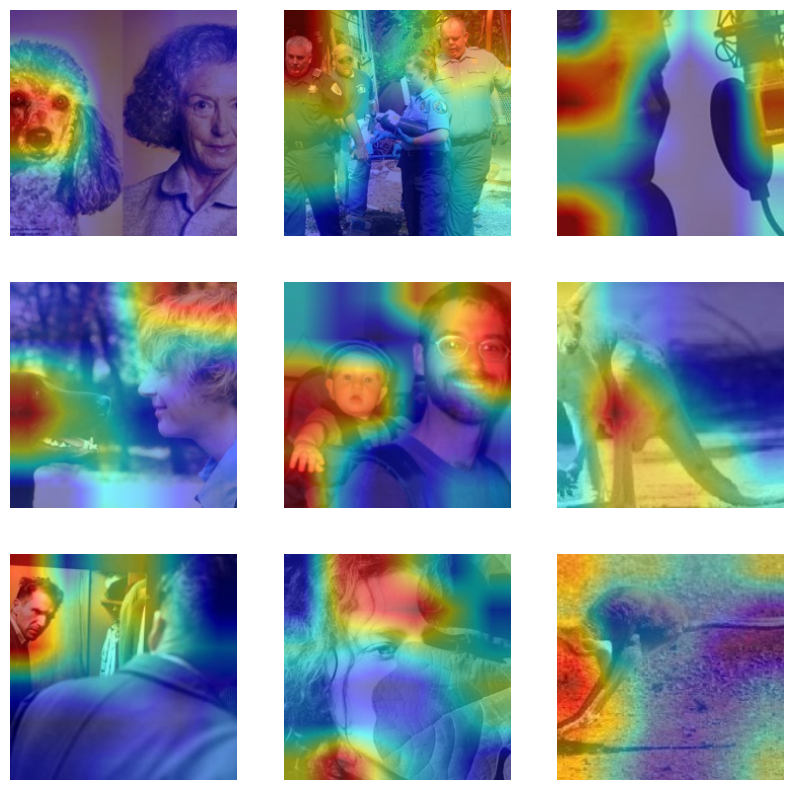

In [22]:
# Visualize gradcam results for untuned model

# Create gradcam model
untuned_model_gradcam = gradcam_model(untuned_model, num_classes, cl_model=False)
untuned_classifier_w, untuned_classifier_b = joblib.load(untuned_classifier_path)['Untuned']

# Manually input weights from log regression classifier
with torch.no_grad():
    untuned_model_gradcam.classification_head.weight = torch.nn.Parameter(torch.tensor(untuned_classifier_w).to(torch.float))
    untuned_model_gradcam.classification_head.bias = torch.nn.Parameter(torch.tensor(untuned_classifier_b).to(torch.float))
untuned_model_gradcam.to(device)

# Set target layer as last convolutional layer
target_layer = [untuned_model_gradcam.features[12]]

# Set up GradCAM object
untuned_cam = GradCAM(model=untuned_model_gradcam, target_layers=target_layer)

# Display untuned gradcam maps in a grid
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
counter = 0
x = 0
y = 0
image_labels = [56, 56, 159, 159, 159, 159, 159, 121, 121]
for counter, img_path in enumerate(img_paths):

    img_label = image_labels[counter] - 1
    label_name = img_path.split('/')[0].split('-')[0][34:]

    img = Image.open(img_paths[counter]).convert('RGB')
    img_model_input = alex_transform(img).to(device).unsqueeze(dim=0)
    img_plot = plot_transform(img)

    print("Label", img_label)
    print("Predicted Label:", torch.argmax(untuned_model_gradcam(img_model_input)))

    targets = [ClassifierOutputTarget(img_label)]  # Use true label  
    grayscale_cam = untuned_cam(input_tensor=img_model_input, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=grayscale_cam, use_rgb=True)
    ax[x, y].imshow(visualization)
    ax[x, y].axis('off')
    ax[x, y].set_title(label_name)

    x += 1
    if x == 3:
        x = 0
        y += 1
    counter += 1

## CL-tuned GradCAM

In [33]:
subj = 1
hemisphere = 'right'
roi = 'V2v'
hemisphere_abbr = 'lh' if hemisphere == 'left' else 'rh'
num_voxels = 887

In [34]:
# Load CL-tuned model
alex_out_layer_dim = 4096
alex_out_layer = 'classifier.5'
cl_model_dir = os.path.join(project_dir, "cl_models", "Subj" + str(subj))
cl_model_path = os.path.join(cl_model_dir, "subj" + str(subj) + "_" + hemisphere_abbr + "_" + roi + "_model_e30.pt")

h_dim = int(num_voxels*0.8)
z_dim = int(num_voxels*0.2)
cl_model = CLR_model(num_voxels, h_dim, z_dim)

# Some models seem to be saved differently
try:
    cl_model.load_state_dict(torch.load(cl_model_path, map_location=torch.device('cpu'))[0].state_dict())
except:
    try:
        cl_model.load_state_dict(torch.load(cl_model_path, map_location=torch.device('cpu')).state_dict())
    except:
        cl_model.load_state_dict(torch.load(cl_model_path, map_location=torch.device('cpu')))

cl_model.to(device)
cl_model.eval();

Using cache found in /Users/alexm/.cache/torch/hub/pytorch_vision_v0.10.0


In [35]:
cl_classifier_path = os.path.join(project_dir, "results", "Subj" + str(subj), "subj" + str(subj) + "_" + hemisphere_abbr + "_caltech256_cl_classifier.joblib")
cl_classifier_w, cl_classifier_b = joblib.load(cl_classifier_path)[roi]

Label: 55 Predicted Label: tensor(55)
Label: 55 Predicted Label: tensor(55)
Label: 158 Predicted Label: tensor(172)
Label: 158 Predicted Label: tensor(172)
Label: 158 Predicted Label: tensor(158)
Label: 158 Predicted Label: tensor(158)
Label: 158 Predicted Label: tensor(158)
Label: 120 Predicted Label: tensor(120)
Label: 120 Predicted Label: tensor(39)


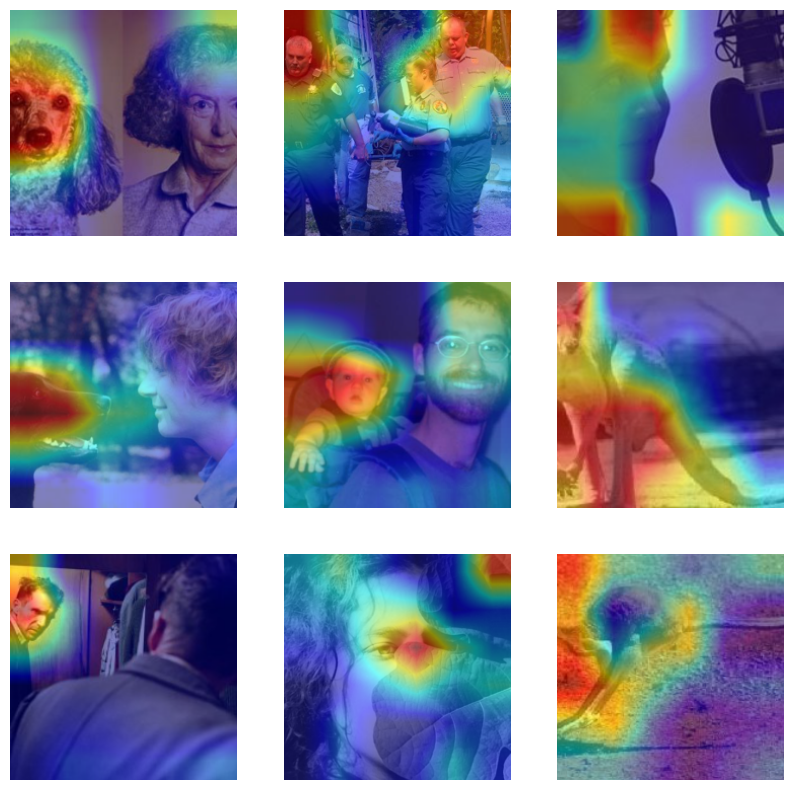

In [37]:
# Visualize gradcam results for CL-tuned model
cl_model_gradcam = gradcam_model(cl_model, num_classes, cl_model=True)

cl_classifier_w, cl_classifier_b = joblib.load(cl_classifier_path)[roi]
# Manually input weights from log regression classifier
with torch.no_grad():
    cl_model_gradcam.classification_head.weight = torch.nn.Parameter(torch.tensor(cl_classifier_w).to(torch.float))
    cl_model_gradcam.classification_head.bias = torch.nn.Parameter(torch.tensor(cl_classifier_b).to(torch.float))

cl_model_gradcam.to(device)

# Set target layer as last convolutional layer
target_layer = [cl_model_gradcam.features[12]]

# Set up GradCAM object
cl_cam = GradCAM(model=cl_model_gradcam, target_layers=target_layer)

# Display untuned gradcam maps in a grid
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
counter = 0
x = 0
y = 0
image_labels = [56, 56, 159, 159, 159, 159, 159, 121, 121]
for counter, img_path in enumerate(img_paths):

    img_label = image_labels[counter] - 1
    label_name = img_path.split('/')[0].split('-')[0][34:]

    img = Image.open(img_paths[counter]).convert('RGB')
    img_model_input = alex_transform(img).to(device).unsqueeze(dim=0)
    img_plot = plot_transform(img)

    print("Label:", img_label, "Predicted Label:", torch.argmax(cl_model_gradcam(img_model_input)))

    targets = [ClassifierOutputTarget(img_label)]  # Use true label  
    grayscale_cam = cl_cam(input_tensor=img_model_input, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=grayscale_cam, use_rgb=True)
    ax[x, y].imshow(visualization)
    ax[x, y].axis('off')
    ax[x, y].set_title(label_name)

    x += 1
    if x == 3:
        x = 0
        y += 1
    counter += 1

## Untuned vs. Tuned Comparison

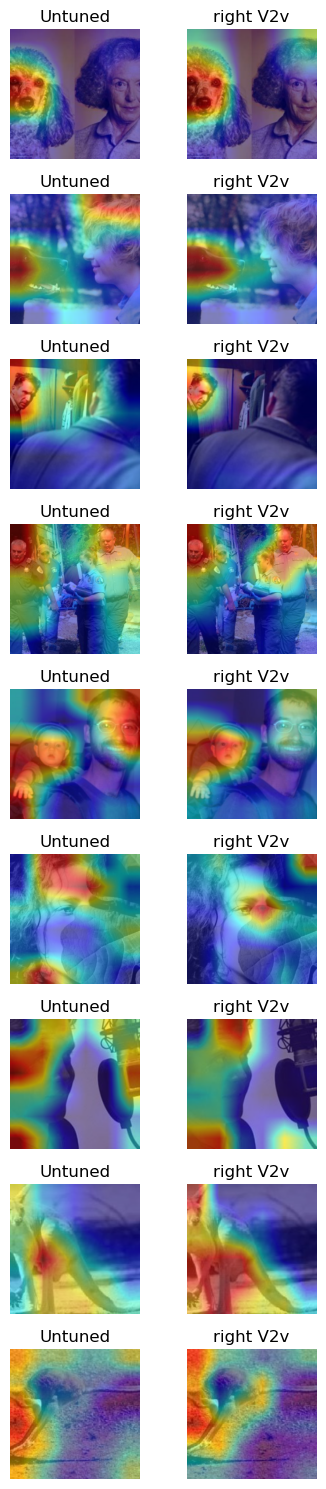

In [38]:
# Visualize gradcam results for untuned model and tuned model in same plot

fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(4,15))
counter = 0
image_labels = [56, 56, 159, 159, 159, 159, 159, 121, 121]
for counter, img_path in enumerate(img_paths):

    img_label = image_labels[counter] - 1
    label_name = img_path.split('/')[0].split('-')[0][34:]

    img = Image.open(img_paths[counter]).convert('RGB')
    img_model_input = alex_transform(img).to(device).unsqueeze(dim=0)
    img_plot = plot_transform(img)

    targets = [ClassifierOutputTarget(img_label)]  # Use true label  
    cl_grayscale_cam = cl_cam(input_tensor=img_model_input, targets=targets)
    untuned_grayscale_cam = untuned_cam(input_tensor=img_model_input, targets=targets)
    cl_grayscale_cam = cl_grayscale_cam[0, :]
    untuned_grayscale_cam = untuned_grayscale_cam[0, :]
    cl_visualization = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=cl_grayscale_cam, use_rgb=True)
    untuned_visualization = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=untuned_grayscale_cam, use_rgb=True)
    ax[counter, 0].imshow(untuned_visualization)
    ax[counter, 1].imshow(cl_visualization)
    ax[counter, 0].axis('off')
    ax[counter, 1].axis('off')
    ax[counter, 0].set_title("Untuned")
    ax[counter, 1].set_title(hemisphere + " " + roi)

    counter += 1
plt.tight_layout()

## Compare left vs right early visual ROI to untuned

In [85]:
subj = 1
roi = 'V2v'
num_voxels_lh = 632
num_voxels_rh = 887

In [86]:
# Load CL-tuned model

alex_out_layer_dim = 4096
alex_out_layer = 'classifier.5'
cl_model_dir = project_dir + r"/cl_models/Subj" + str(subj)
cl_model_path_lh = cl_model_dir + r"/subj" + str(subj) + "_lh_" + roi + "_model_e30.pt"
cl_model_path_rh = cl_model_dir + r"/subj" + str(subj) + "_rh_" + roi + "_model_e30.pt"

h_dim_lh = int(num_voxels_lh*0.8)
z_dim_lh = int(num_voxels_lh*0.2)
cl_model_lh = CLR_model(num_voxels_lh, h_dim_lh, z_dim_lh)
h_dim_rh = int(num_voxels_rh*0.8)
z_dim_rh = int(num_voxels_rh*0.2)
cl_model_rh = CLR_model(num_voxels_rh, h_dim_rh, z_dim_rh)

# Some models seem to be saved differently
try:
    cl_model_lh.load_state_dict(torch.load(cl_model_path_lh, map_location=torch.device('cpu'), weights_only=False)[0].state_dict())
except:
    try:
        cl_model_lh.load_state_dict(torch.load(cl_model_path_lh, map_location=torch.device('cpu'), weights_only=False).state_dict())
    except:
        cl_model_lh.load_state_dict(torch.load(cl_model_path_lh, map_location=torch.device('cpu'), weights_only=False))
try:
    cl_model_rh.load_state_dict(torch.load(cl_model_path_rh, map_location=torch.device('cpu'), weights_only=False)[0].state_dict())
except:
    try:
        cl_model_rh.load_state_dict(torch.load(cl_model_path_rh, map_location=torch.device('cpu'), weights_only=False).state_dict())
    except:
        cl_model_rh.load_state_dict(torch.load(cl_model_path_rh, map_location=torch.device('cpu'), weights_only=False))

cl_model_lh.to(device)
cl_model_lh.eval()
cl_model_rh.to(device)
cl_model_rh.eval();

Using cache found in /Users/alexm/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/alexm/.cache/torch/hub/pytorch_vision_v0.10.0


In [87]:
cl_classifier_path_lh = os.path.join(project_dir, "results", "Subj" + str(subj), "subj" + str(subj) + "_lh_caltech256_cl_classifier.joblib")
cl_classifier_w_lh, cl_classifier_b_lh = joblib.load(cl_classifier_path_lh)[roi]
cl_classifier_path_rh = os.path.join(project_dir, "results", "Subj" + str(subj), "subj" + str(subj) + "_rh_caltech256_cl_classifier.joblib")
cl_classifier_w_rh, cl_classifier_b_rh = joblib.load(cl_classifier_path_rh)[roi]

In [88]:
cl_model_gradcam_lh = gradcam_model(cl_model_lh, num_classes, cl_model=True)
cl_classifier_w_lh, cl_classifier_b_lh = joblib.load(cl_classifier_path_lh)[roi]
# Manually input weights from log regression classifier
with torch.no_grad():
    cl_model_gradcam_lh.classification_head.weight = torch.nn.Parameter(torch.tensor(cl_classifier_w_lh).to(torch.float))
    cl_model_gradcam_lh.classification_head.bias = torch.nn.Parameter(torch.tensor(cl_classifier_b_lh).to(torch.float))
cl_model_gradcam_lh.to(device)
# Set target layer as last convolutional layer
target_layer = [cl_model_gradcam_lh.features[12]]
# Set up GradCAM object
cl_cam_lh = GradCAM(model=cl_model_gradcam_lh, target_layers=target_layer)

cl_model_gradcam_rh = gradcam_model(cl_model_rh, num_classes, cl_model=True)
cl_classifier_w_rh, cl_classifier_b_rh = joblib.load(cl_classifier_path_rh)[roi]
# Manually input weights from log regression classifier
with torch.no_grad():
    cl_model_gradcam_rh.classification_head.weight = torch.nn.Parameter(torch.tensor(cl_classifier_w_rh).to(torch.float))
    cl_model_gradcam_rh.classification_head.bias = torch.nn.Parameter(torch.tensor(cl_classifier_b_rh).to(torch.float))
cl_model_gradcam_rh.to(device)
# Set target layer as last convolutional layer
target_layer = [cl_model_gradcam_rh.features[12]]
# Set up GradCAM object
cl_cam_rh = GradCAM(model=cl_model_gradcam_rh, target_layers=target_layer)

In [139]:
plt.rcParams.update({
    'font.family':   'serif',
    'font.serif':    ['Times New Roman', 'Times', 'DejaVu Serif'], 
    'mathtext.fontset': 'stix',  
    'axes.unicode_minus': False,
})

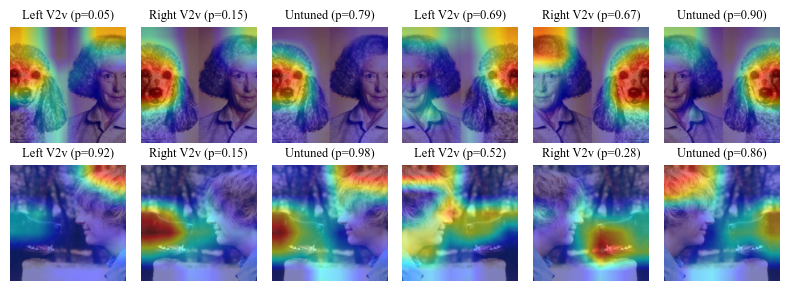

In [144]:
# Visualize gradcam results for left and right ROI model in same plot

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(8,3))
counter = 0
for counter, img_path in enumerate(img_paths[:2]):

    img_label = 55   # Dog - 1
    label_name = "Dog"

    img = Image.open(img_paths[counter]).convert('RGB')
    img_flip = transforms.functional.hflip(img)
    img_model_input = alex_transform(img).to(device).unsqueeze(dim=0)
    img_model_input_flip =  alex_transform(img_flip).to(device).unsqueeze(dim=0)
    img_plot = plot_transform(img)
    img_plot_flip = plot_transform(img_flip)

    lh_preds_softmax = torch.nn.functional.softmax(cl_model_gradcam_lh(img_model_input)[0], dim=0)
    lh_true_class_prob = lh_preds_softmax[img_label]
    lh_preds_softmax_flip = torch.nn.functional.softmax(cl_model_gradcam_lh(img_model_input_flip)[0], dim=0)
    lh_true_class_prob_flip = lh_preds_softmax_flip[img_label]
    rh_preds_softmax = torch.nn.functional.softmax(cl_model_gradcam_rh(img_model_input)[0], dim=0)
    rh_true_class_prob = rh_preds_softmax[img_label]
    rh_preds_softmax_flip = torch.nn.functional.softmax(cl_model_gradcam_rh(img_model_input_flip)[0], dim=0)
    rh_true_class_prob_flip = rh_preds_softmax_flip[img_label]

    targets = [ClassifierOutputTarget(img_label)]  # Use true label  

    cl_grayscale_cam_lh = cl_cam_lh(input_tensor=img_model_input, targets=targets)
    cl_grayscale_cam_lh = cl_grayscale_cam_lh[0, :]
    cl_visualization_lh = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=cl_grayscale_cam_lh, use_rgb=True)
    cl_grayscale_cam_rh = cl_cam_rh(input_tensor=img_model_input, targets=targets)
    cl_grayscale_cam_rh = cl_grayscale_cam_rh[0, :]
    cl_visualization_rh = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=cl_grayscale_cam_rh, use_rgb=True)
    untuned_grayscale_cam = untuned_cam(input_tensor=img_model_input, targets=targets)
    untuned_grayscale_cam = untuned_grayscale_cam[0, :]
    untuned_visualization = show_cam_on_image(img=img_plot.permute(1, 2, 0).numpy(), mask=untuned_grayscale_cam, use_rgb=True)

    cl_grayscale_cam_lh_flip = cl_cam_lh(input_tensor=img_model_input_flip, targets=targets)
    cl_grayscale_cam_lh_flip = cl_grayscale_cam_lh_flip[0, :]
    cl_visualization_lh_flip = show_cam_on_image(img=img_plot_flip.permute(1, 2, 0).numpy(), mask=cl_grayscale_cam_lh_flip, use_rgb=True)
    cl_grayscale_cam_rh_flip = cl_cam_rh(input_tensor=img_model_input_flip, targets=targets)
    cl_grayscale_cam_rh_flip = cl_grayscale_cam_rh_flip[0, :]
    cl_visualization_rh_flip = show_cam_on_image(img=img_plot_flip.permute(1, 2, 0).numpy(), mask=cl_grayscale_cam_rh_flip, use_rgb=True)
    untuned_grayscale_cam_flip = untuned_cam(input_tensor=img_model_input_flip, targets=targets)
    untuned_grayscale_cam_flip = untuned_grayscale_cam_flip[0, :]
    untuned_visualization_flip = show_cam_on_image(img=img_plot_flip.permute(1, 2, 0).numpy(), mask=untuned_grayscale_cam_flip, use_rgb=True)

    ax[counter, 0].imshow(cl_visualization_lh)
    ax[counter, 3].imshow(cl_visualization_lh_flip)
    ax[counter, 1].imshow(cl_visualization_rh)
    ax[counter, 4].imshow(cl_visualization_rh_flip)
    ax[counter, 2].imshow(untuned_visualization)
    ax[counter, 5].imshow(untuned_visualization_flip)
    for i in range(6):
        ax[counter, i].axis('off')
    ax[counter, 0].set_title("Left " + roi + " (p=" + str(lh_true_class_prob.item())[:4] + ")", fontsize=9)
    ax[counter, 3].set_title("Left " + roi + " (p=" + str(rh_true_class_prob.item())[:4] + ")", fontsize=9)
    ax[counter, 1].set_title("Right " + roi + " (p=" + str(lh_true_class_prob_flip.item())[:4] + ")", fontsize=9)
    ax[counter, 4].set_title("Right " + roi + " (p=" + str(rh_true_class_prob_flip.item())[:4] + ")", fontsize=9)
    if counter == 0:
        ax[counter, 2].set_title("Untuned (p=0.79)", fontsize=9)
        ax[counter, 5].set_title("Untuned (p=0.90)", fontsize=9)
    elif counter == 1:
        ax[counter, 2].set_title("Untuned (p=0.98)", fontsize=9)
        ax[counter, 5].set_title("Untuned (p=0.86)", fontsize=9)

    counter += 1
plt.tight_layout()
plt.savefig(os.path.join(project_dir, "src", "paper_figs", "gradcam_img.tiff"), dpi=300, pil_kwargs=dict(compression='tiff_lzw'))
plt.savefig(os.path.join(project_dir, "src", "paper_figs", "gradcam_img.pdf"), dpi=300)